# Background: 
You are the Data Scientist for XYZ Pharma.  In recent months, one of the Therapy area teams, with Brands A and B, launched initiatives to gain consent to digitally connect with customers, a critical part in developing effective customer relationships.  Thus far, **results have been disappointing** and the team has turned to you for help in improving the situation.  In the next worksheet (Data), you'll see some data with customer ID's, consent status - ie: Opt In = Yes, YTD Customer Calls and YTD Sales.  You have been asked to provide initial observations and proposed approach to the Business Unit Head later this week.
# Objective: 
To find out ways to improve customer consent to connect. 

# Key questions to be answered:

* What kind of customers agree to be contacted? Are there any demographics that we can generalize? (Calls, Provinces?)
* Does a customer respond well after a certain sale threshold has been reached?
* How does the customer opt-ins vary across differnet labels (Brand A and Brand B?)
* How does the customer opt-ins vary across differnet Segments? 

# Dataset :

* CustomerID: Customer Identifier
* Province: Various provinces of Canada
* Speciality1: Pharma speciality for associated customer
* Consent_Status: OPT_IN are the customers who decided to opt in. Similarly, OPT_OUT are the customers who decided to opt out
* Segment 1 Status: Segment 1 refers to the internal segmentation provided by Bayer
* YTD Calls: Total Calls made by the customer YTD
* YTD/Total Brand A/B Sales: Value of service. The unit is dollars.



### Import the necessary packages - pandas, numpy, seaborn, matplotlib.pyplot

In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
pd.set_option('display.float_format', lambda x: '%.2f' % x) # To supress numerical display in scientific notations
from sklearn.model_selection import train_test_split



# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
from sklearn.model_selection import GridSearchCV

# To build model for prediction
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
)
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)

### Read in the dataset

In [2]:
data = pd.read_csv("data.csv")

### View the first few rows of the dataset

In [3]:
data.head(10)

,Customer_ID,PROVINCE,Specialty_1,CONSENT STATUS,Segment 1 STATUS,YTD Customer Calls,YTD Brand A New Sales,YTD Brand A Total Sales,YTD Brand B New Sales,YTD Brand B Total Sales
0,1,Manitoba,Family Practice,,N,4,0,0,0,0
1,2,Manitoba,Family Practice,,N,5,0,0,0,0
2,3,Manitoba,Family Practice,,N,7,0,0,0,0
3,4,Saskatchewan,General Practice,,N,0,0,0,0,0
4,5,Ontario,Family Practice,,N,3,0,0,0,0
5,6,Saskatchewan,Family Practice,,N,2,0,15,0,0
6,7,Saskatchewan,General Practice,,N,1,0,40,0,0
7,8,Ontario,Family Practice,OPT IN,N,3,2,5,0,0
8,9,Ontario,Family Practice,OPT IN,N,4,3,29,0,0
9,10,Quebec,Cardiovascular Diseases,,N,6,15,417,1,1


Observations: The dataset looks clean and consistent with the description provided in the Data Dictionary.

### Check the shape of the dataset

In [4]:
data.shape

(13726, 10)

Observations: We have 13726 observations of 10 columns

### Check the datatype of the variables to make sure that the data is read in properly

In [5]:
data.dtypes

Customer_ID                 int64
PROVINCE                   object
Specialty_1                object
CONSENT STATUS             object
Segment 1 STATUS           object
YTD Customer Calls          int64
YTD Brand A New Sales       int64
YTD Brand A Total Sales     int64
YTD Brand B New Sales       int64
YTD Brand B Total Sales     int64
dtype: object

Observations: 
1. Customer_ID is int data type.**Since Customer_ID is a identifier here, let us treat it as a index**
2. PROVINCE,Speciality_1, Consent_status and Segment1 Status are objects and treated as such 
3. All the other variables are numerical and there for their python data types (int64) are ok.

In [6]:
data.set_index('Customer_ID',inplace=True)
data.head()


,PROVINCE,Specialty_1,CONSENT STATUS,Segment 1 STATUS,YTD Customer Calls,YTD Brand A New Sales,YTD Brand A Total Sales,YTD Brand B New Sales,YTD Brand B Total Sales
Customer_ID,,,,,,,,,
1,Manitoba,Family Practice,,N,4,0,0,0,0
2,Manitoba,Family Practice,,N,5,0,0,0,0
3,Manitoba,Family Practice,,N,7,0,0,0,0
4,Saskatchewan,General Practice,,N,0,0,0,0,0
5,Ontario,Family Practice,,N,3,0,0,0,0


In [7]:
data['CONSENT STATUS'].value_counts()

           9315
OPT IN     4300
OPT OUT     111
Name: CONSENT STATUS, dtype: int64

Observations:
1. Blanks are treated as values in CONSENT_STATUS

### Looking at the Nulls in the dataset

In [8]:
data.isna().sum()

PROVINCE                   43
Specialty_1                 0
CONSENT STATUS              0
Segment 1 STATUS            0
YTD Customer Calls          0
YTD Brand A New Sales       0
YTD Brand A Total Sales     0
YTD Brand B New Sales       0
YTD Brand B Total Sales     0
dtype: int64

Replacing blanks with Nulls

In [9]:
data=data.replace(r'^\s*$', np.nan, regex=True)
data.isna().sum()

PROVINCE                     43
Specialty_1                   0
CONSENT STATUS             9315
Segment 1 STATUS              0
YTD Customer Calls            0
YTD Brand A New Sales         0
YTD Brand A Total Sales       0
YTD Brand B New Sales         0
YTD Brand B Total Sales       0
dtype: int64

Observations:
 1. Since there are 9,315 (67%) blank observations in consent_status, it is better to treat them as 'unknowns'
 2. We can get rid of the NAs in province since those are lower numbers (0.3%)

### Treating NA values

In [10]:
data['CONSENT STATUS'] = data['CONSENT STATUS'].fillna('Unknown')
data.isna().sum()

PROVINCE                   43
Specialty_1                 0
CONSENT STATUS              0
Segment 1 STATUS            0
YTD Customer Calls          0
YTD Brand A New Sales       0
YTD Brand A Total Sales     0
YTD Brand B New Sales       0
YTD Brand B Total Sales     0
dtype: int64

In [11]:
data['CONSENT STATUS'].value_counts()

Unknown    9315
OPT IN     4300
OPT OUT     111
Name: CONSENT STATUS, dtype: int64

We can observe that the nulls have been replaced with 'Unknowns'

In [12]:
data=data.dropna()
data.isna().sum()

PROVINCE                   0
Specialty_1                0
CONSENT STATUS             0
Segment 1 STATUS           0
YTD Customer Calls         0
YTD Brand A New Sales      0
YTD Brand A Total Sales    0
YTD Brand B New Sales      0
YTD Brand B Total Sales    0
dtype: int64

In [13]:
data.shape

(13683, 9)

After removing for Nulls, there are 13,683 values left

### Let us analyse the quantitative variables in the dataset

In [14]:
data.describe()

,YTD Customer Calls,YTD Brand A New Sales,YTD Brand A Total Sales,YTD Brand B New Sales,YTD Brand B Total Sales
count,13683.00,13683.00,13683.00,13683.00,13683.00
mean,2.42,2.35,94.31,0.36,2.21
std,2.04,4.98,145.48,2.87,18.16
min,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,2.00,0.00,0.00
50%,2.00,1.00,42.00,0.00,0.00
75%,3.00,3.00,123.00,0.00,0.00
max,17.00,73.00,1433.00,59.00,364.00


Observations:

1. The mean of all numerical columns is close to the 75% percentile of the data, indicating a right skew.
2. Standard deviation of YTD Brand A Total Sales is very high
3. New Sales for Brand A/B is really low with 0 as the median and outliers present
4. Infact, all the variable seem to have a huge range, we will have to investigate further if this spread is mainly across different provinces or attributes



#### Looking at the relationship between numerical variables using pair plots and correlation plots


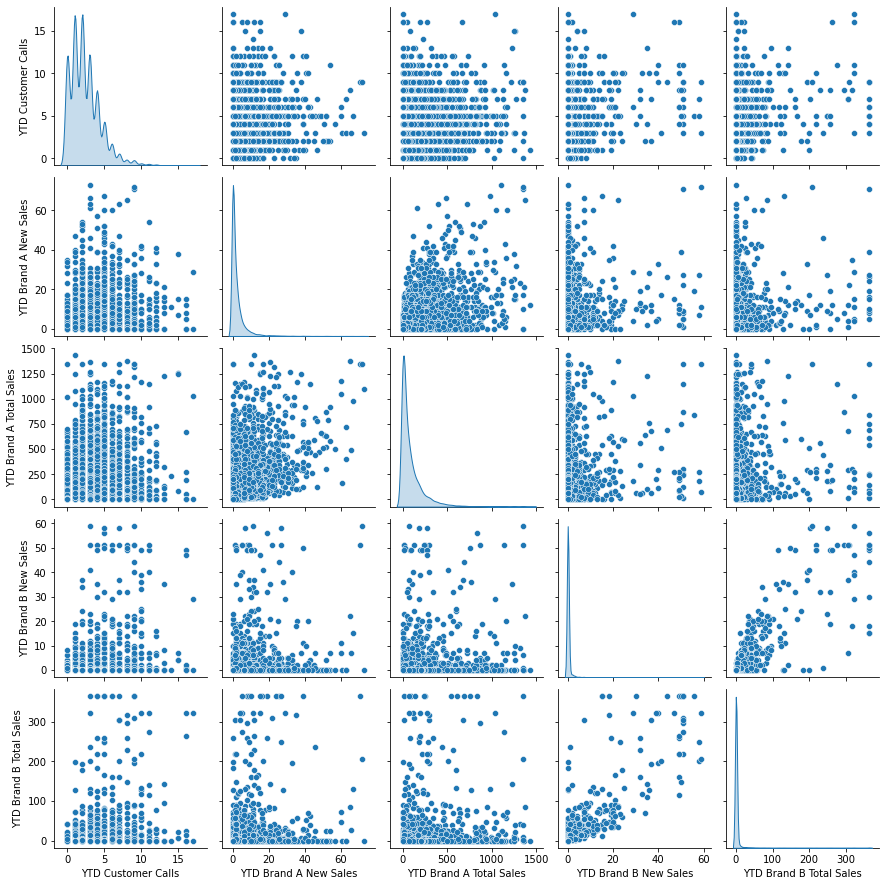

In [15]:
sns.pairplot(data, diag_kind="kde")

In [16]:
# function to plot a boxplot and a histogram along the same scale.

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [17]:


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [18]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

### Exploratory Data Analysis (EDA)

#### Univariate Analysis

In [19]:
data.columns

Index(['PROVINCE', 'Specialty_1', 'CONSENT STATUS', 'Segment 1 STATUS',
       'YTD Customer Calls', 'YTD Brand A New Sales',
       'YTD Brand A Total Sales', 'YTD Brand B New Sales',
       'YTD Brand B Total Sales'],
      dtype='object')

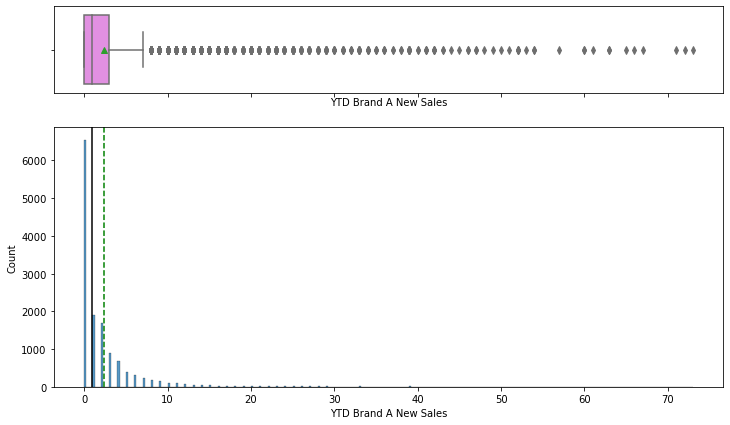

In [20]:
histogram_boxplot(data, 'YTD Brand A New Sales')

Observations:
1. YTD Brand A New Sales is highly skewed to the right
2. Median Sales ~3 with outliers

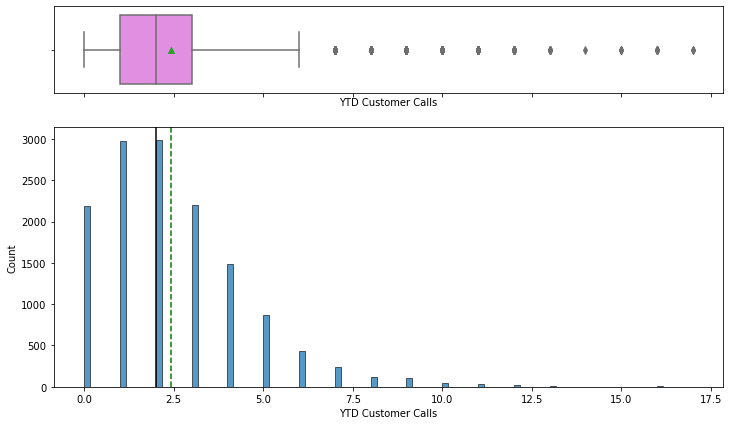

In [21]:
histogram_boxplot(data, 'YTD Customer Calls')

Observations:
1. YTD Customer Calls is skewed to the right
2. Median calls ~2.5 with outliers

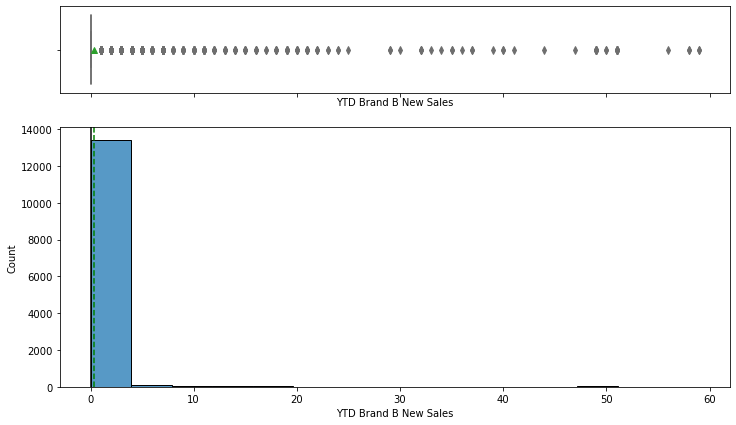

In [22]:
histogram_boxplot(data, 'YTD Brand B New Sales')

Observations:
1. YTD Brand B New Sales is highly skewed to the right
2. Median sale 0 with outliers

#### Categorical Data

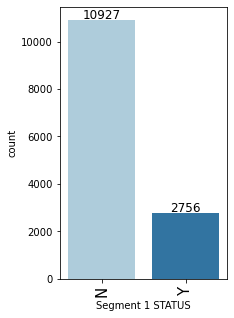

In [23]:
labeled_barplot(data, 'Segment 1 STATUS')

Observation- High amount of "N" in Segment1 Status

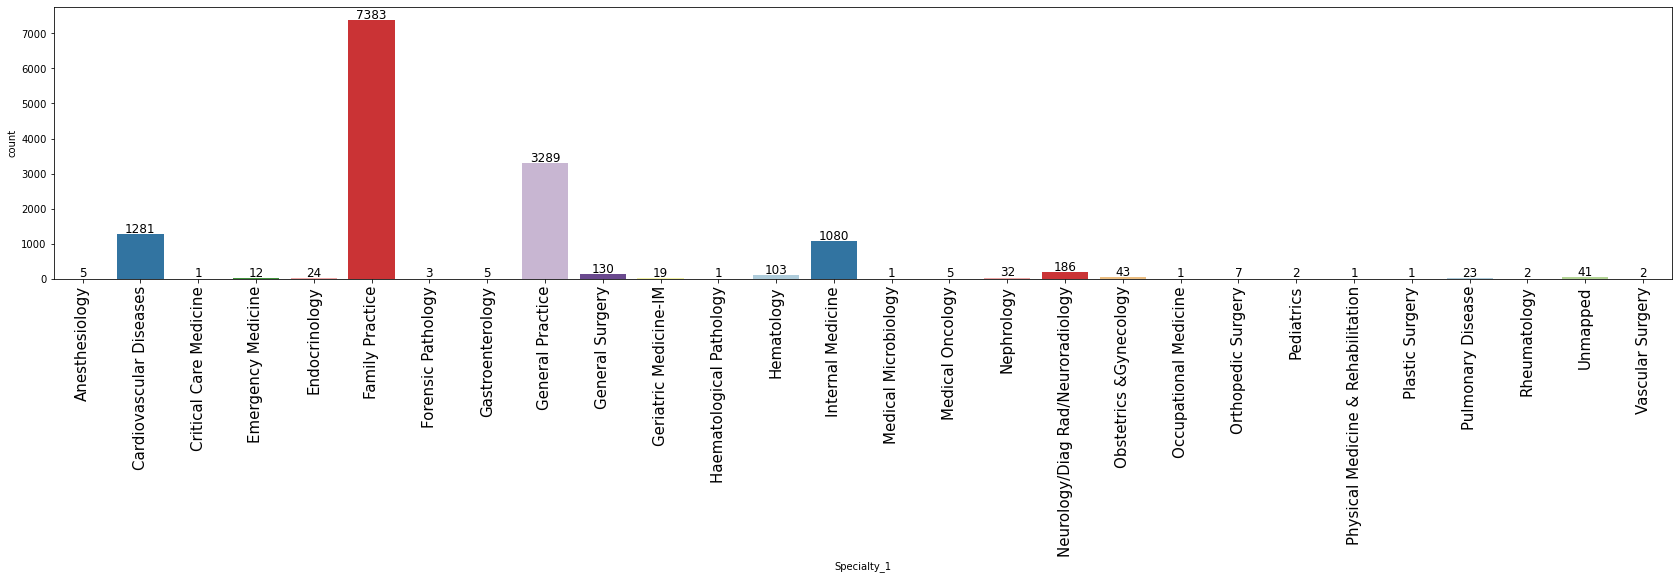

In [24]:
labeled_barplot(data, 'Specialty_1')

Observation- Since most of the Sepciality have less than 1000 records, we can aggregate them under a separate category

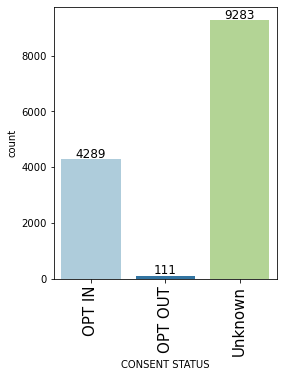

In [25]:
labeled_barplot(data, 'CONSENT STATUS')

Observation- In order to make things unbiased, we can add OPT_OUT and Unknown together in one category. Intuitively, it makes sense. Customers who dont want to be contacted will not respond

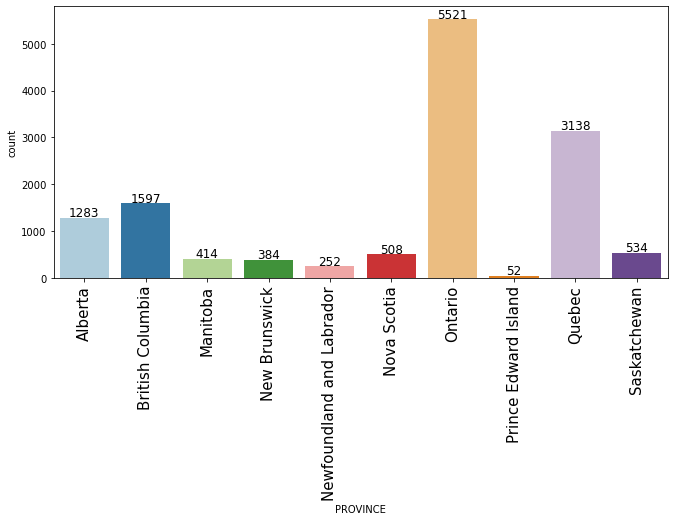

In [26]:
labeled_barplot(data, 'PROVINCE')

Observation- Since most of the provinces have less than 1000 records, we can aggregate them under a separate category

#### Multivariate Analysis

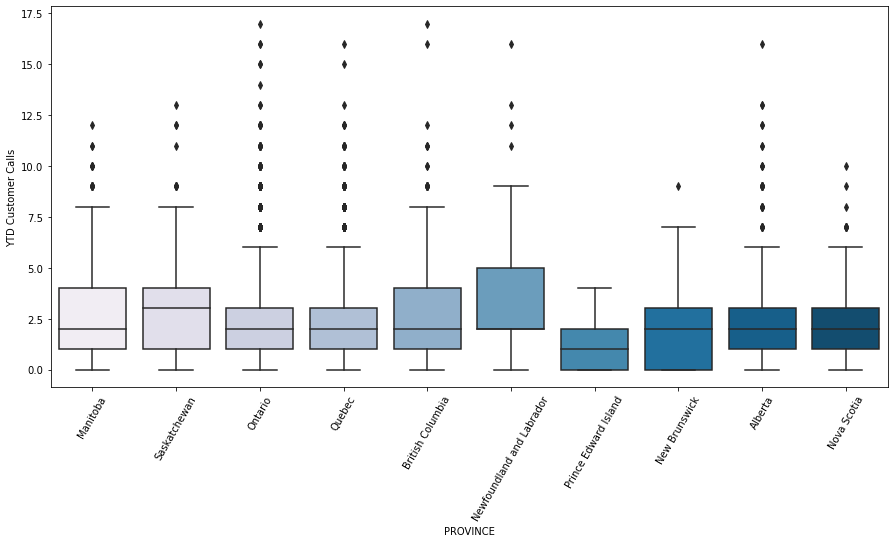

In [27]:
# Relationship between cost of the order and cuisine type
plt.figure(figsize=(15,7))
sns.boxplot(x = "PROVINCE", y = "YTD Customer Calls", data = data, palette = 'PuBu')
plt.xticks(rotation = 60)
plt.show()

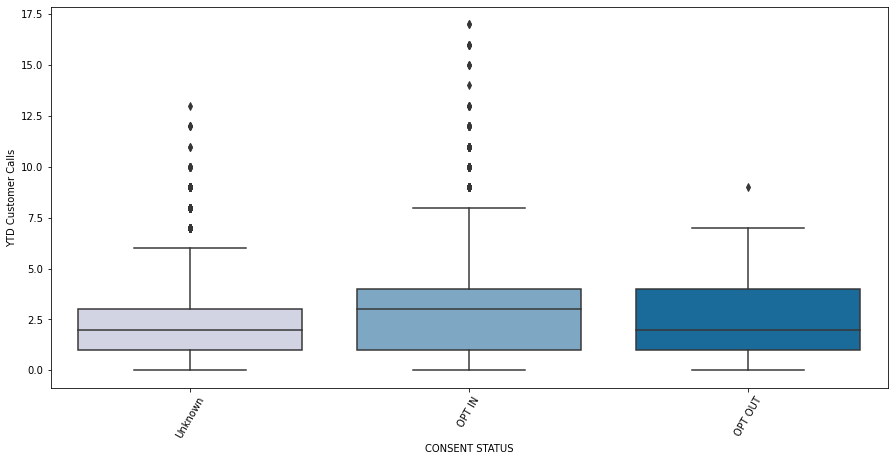

In [28]:
plt.figure(figsize=(15,7))
sns.boxplot(x = "CONSENT STATUS", y = "YTD Customer Calls", data = data, palette = 'PuBu')
plt.xticks(rotation = 60)
plt.show()

Observation- People who decided to OPT_IN had a higher #Customer Calls

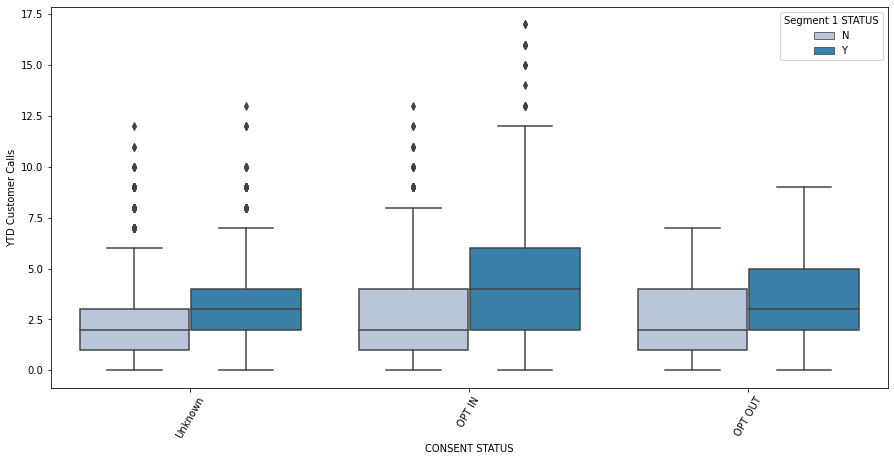

In [29]:
plt.figure(figsize=(15,7))
sns.boxplot(x = "CONSENT STATUS", y = "YTD Customer Calls", data = data, palette = 'PuBu',hue="Segment 1 STATUS")
plt.xticks(rotation = 60)
plt.show()

Observation- People with Segment Status Y had higher customer calls in general

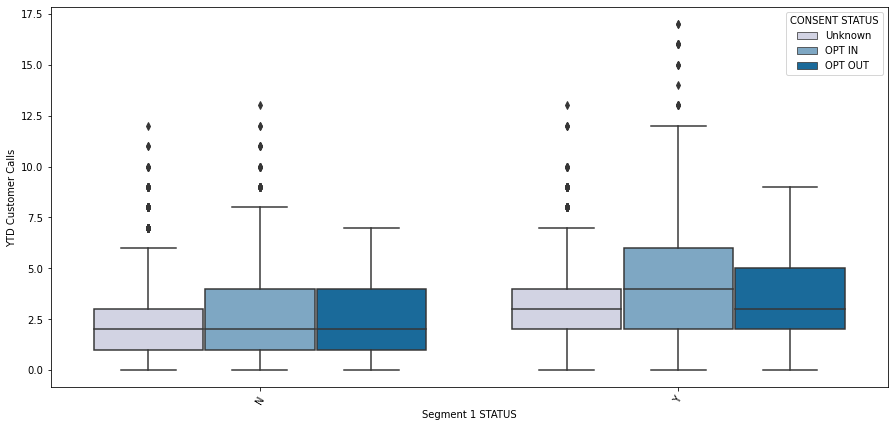

In [30]:

plt.figure(figsize=(15,7))
sns.boxplot(x = "Segment 1 STATUS", y = "YTD Customer Calls", data = data, palette = 'PuBu',hue='CONSENT STATUS')
plt.xticks(rotation = 60)
plt.show()

Observation-People in Segment1 Status 'Y' decided to OPT_IN more and had higher calls

### Relationship between Categorical Variables

In [31]:
data.columns

Index(['PROVINCE', 'Specialty_1', 'CONSENT STATUS', 'Segment 1 STATUS',
       'YTD Customer Calls', 'YTD Brand A New Sales',
       'YTD Brand A Total Sales', 'YTD Brand B New Sales',
       'YTD Brand B Total Sales'],
      dtype='object')

CONSENT STATUS    OPT IN  OPT OUT  Unknown    All
Segment 1 STATUS                                 
All                 4289      111     9283  13683
N                   3012       82     7833  10927
Y                   1277       29     1450   2756
------------------------------------------------------------------------------------------------------------------------


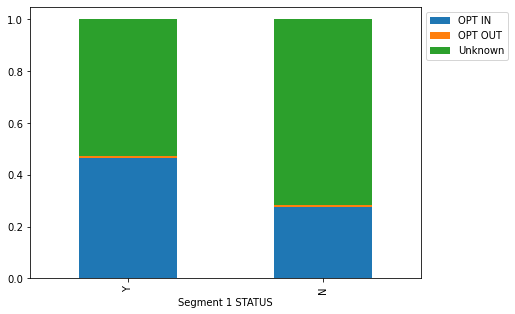

In [32]:
stacked_barplot(data, "Segment 1 STATUS", "CONSENT STATUS")


Observation: People with Segment Status 1 tend to have a higher Consent status

CONSENT STATUS             OPT IN  OPT OUT  Unknown    All
PROVINCE                                                  
All                          4289      111     9283  13683
Ontario                      1840       43     3638   5521
Quebec                        697       27     2414   3138
British Columbia              594       17      986   1597
Alberta                       393        9      881   1283
Manitoba                      197        6      211    414
Newfoundland and Labrador     100        3      149    252
Saskatchewan                  183        3      348    534
New Brunswick                 117        2      265    384
Nova Scotia                   156        1      351    508
Prince Edward Island           12        0       40     52
------------------------------------------------------------------------------------------------------------------------


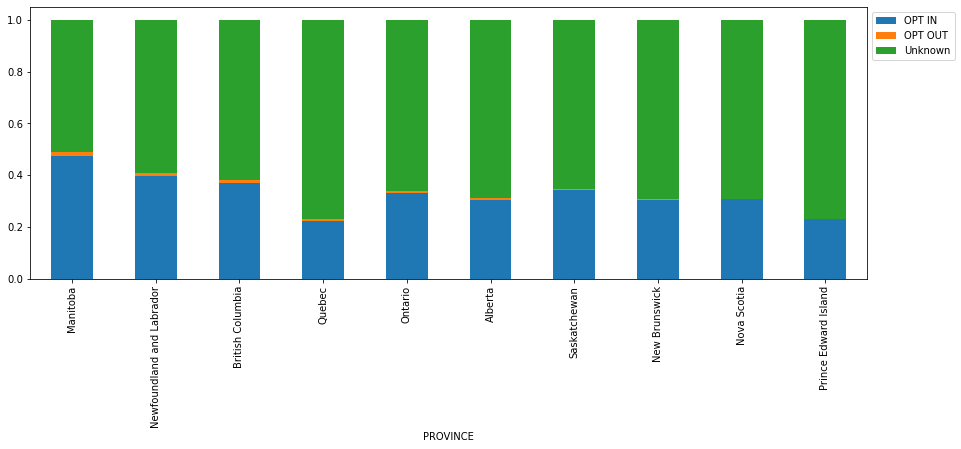

In [33]:
stacked_barplot(data, "PROVINCE", "CONSENT STATUS")


Observations: Top three provinces with highest consent status (% of total population)-
1. Manitoba (~47%)
2. NF and Labrador (~40%)
3. British Columbia (~37%)

CONSENT STATUS                      OPT IN  OPT OUT  Unknown    All
Specialty_1                                                        
All                                   4289      111     9283  13683
Family Practice                       2081       60     5242   7383
General Practice                      1101       29     2159   3289
Cardiovascular Diseases                585       11      685   1281
Internal Medicine                      321        7      752   1080
Geriatric Medicine-IM                    6        2       11     19
Pulmonary Disease                        3        1       19     23
Hematology                              49        1       53    103
Unmapped                                 6        0       35     41
Rheumatology                             0        0        2      2
Vascular Surgery                         0        0        2      2
Plastic Surgery                          0        0        1      1
Obstetrics &Gynecology                  19      

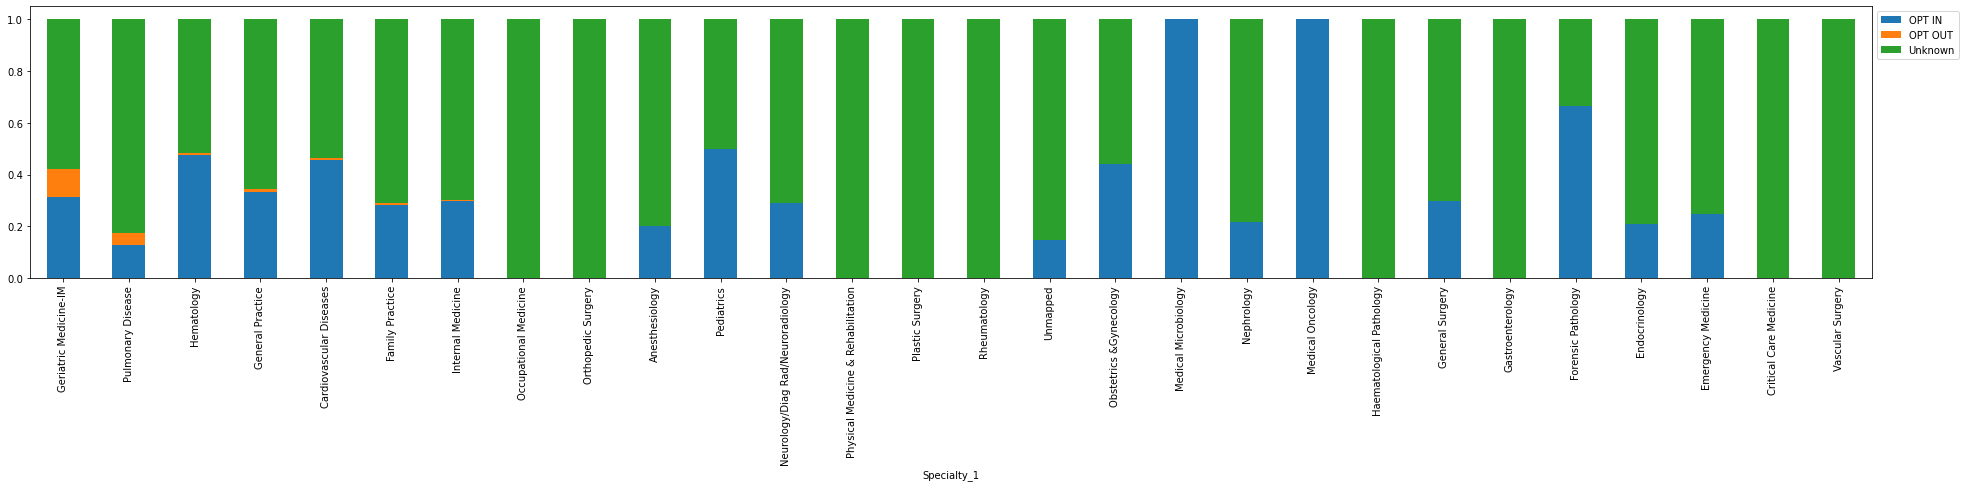

In [34]:
stacked_barplot(data, "Specialty_1", "CONSENT STATUS")

Observations:
The following specialites have very high consent status
1. Medical Microbiology
2. Medical Oncology
3. Pediatrics
4. Forensic 

The data needs to be taken with a pinch of salt since the observations for these specialities is really low. We need to gather more data to find out if there exists a relationship between consent status and specialities

### Correlation between numerical variables

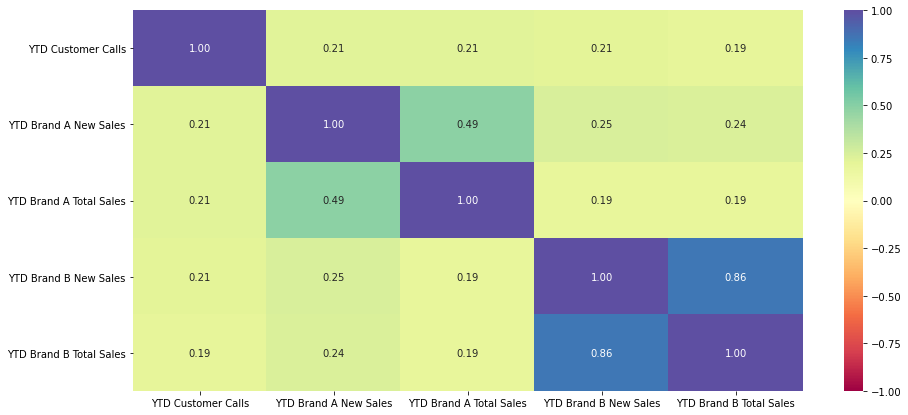

In [35]:
# plot the heatmap 
col_list = ['YTD Customer Calls','YTD Brand A New Sales','YTD Brand A Total Sales','YTD Brand B New Sales','YTD Brand B Total Sales']
plt.figure(figsize=(15, 7))
sns.heatmap(data[col_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()


Observation- There is a high correlation between YTD Brand B New Sales and YTD Brand B total Sales. We can remove one of the variables

#### Conclusions-
1. Remove YTD Brand B New Sales- High Correlation with YTD Brand B Total Sales
2. CONSENT STATUS- Add OPT_OUT and Unknown together into one category
3. PROVINCE- Keep all the provinces with lesser than 1000 records into one separate category
4. Specialty_1- Keep all the specialities with lesser than 1000 records into one separate category


#### PROVINCE- Keep all the provinces with lesser than 1000 records into one separate category

In [36]:
province_counts=data['PROVINCE'].value_counts().to_frame('counts').reset_index()
group_province=list(province_counts[province_counts['counts']<=1000]['index'])
data['PROVINCE_AGG']=data['PROVINCE'].apply(lambda x:"Other" if x in group_province else x)
data['PROVINCE_AGG'].value_counts()

Ontario             5521
Quebec              3138
Other               2144
British Columbia    1597
Alberta             1283
Name: PROVINCE_AGG, dtype: int64

In [37]:
data.head()

,PROVINCE,Specialty_1,CONSENT STATUS,Segment 1 STATUS,YTD Customer Calls,YTD Brand A New Sales,YTD Brand A Total Sales,YTD Brand B New Sales,YTD Brand B Total Sales,PROVINCE_AGG
Customer_ID,,,,,,,,,,
1,Manitoba,Family Practice,Unknown,N,4,0,0,0,0,Other
2,Manitoba,Family Practice,Unknown,N,5,0,0,0,0,Other
3,Manitoba,Family Practice,Unknown,N,7,0,0,0,0,Other
4,Saskatchewan,General Practice,Unknown,N,0,0,0,0,0,Other
5,Ontario,Family Practice,Unknown,N,3,0,0,0,0,Ontario


#### Specialty_1- Keep all the specialities with lesser than 1000 records into one separate category

In [38]:
province_counts=data['Specialty_1'].value_counts().to_frame('counts').reset_index()
group_province=list(province_counts[province_counts['counts']<=1000]['index'])
data['Specialty_1_AGG']=data['Specialty_1'].apply(lambda x:"Other" if x in group_province else x)
data['Specialty_1_AGG'].value_counts()

Family Practice            7383
General Practice           3289
Cardiovascular Diseases    1281
Internal Medicine          1080
Other                       650
Name: Specialty_1_AGG, dtype: int64

In [39]:
#removing province and specialty_1 column
data.drop('PROVINCE',axis=1,inplace=True)
data.drop('Specialty_1',axis=1,inplace=True)
data.head()

,CONSENT STATUS,Segment 1 STATUS,YTD Customer Calls,YTD Brand A New Sales,YTD Brand A Total Sales,YTD Brand B New Sales,YTD Brand B Total Sales,PROVINCE_AGG,Specialty_1_AGG
Customer_ID,,,,,,,,,
1,Unknown,N,4,0,0,0,0,Other,Family Practice
2,Unknown,N,5,0,0,0,0,Other,Family Practice
3,Unknown,N,7,0,0,0,0,Other,Family Practice
4,Unknown,N,0,0,0,0,0,Other,General Practice
5,Unknown,N,3,0,0,0,0,Ontario,Family Practice


#### CONSENT STATUS- Add OPT_OUT and Unknown together into one category

In [40]:
data['CONSENT STATUS'].value_counts(normalize=True)

Unknown   0.68
OPT IN    0.31
OPT OUT   0.01
Name: CONSENT STATUS, dtype: float64

In [41]:
#breaking down the dataframe into 2 parts, OPT_IN and OPT_OUT+Unknown
data_optin=data[data['CONSENT STATUS']=='OPT IN']
data_optout=data[data['CONSENT STATUS']!='OPT IN']
data_optout['CONSENT STATUS'].value_counts()

Unknown    9283
OPT OUT     111
Name: CONSENT STATUS, dtype: int64

In [42]:
data_optout['CONSENT STATUS']='OPT OUT'
data_optout['CONSENT STATUS'].unique()

<ipython-input-42-b7a29e36d017>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_optout['CONSENT STATUS']='OPT OUT'


array(['OPT OUT'], dtype=object)

In [43]:
fin_data=pd.concat([data_optout,data_optin],axis=0)
fin_data['CONSENT STATUS'].value_counts()

OPT OUT    9394
OPT IN     4289
Name: CONSENT STATUS, dtype: int64

#### Remove YTD Brand B New Sales

In [44]:
fin_data.drop(['YTD Brand B New Sales'],axis=1,inplace=True)
fin_data.columns

Index(['CONSENT STATUS', 'Segment 1 STATUS', 'YTD Customer Calls',
       'YTD Brand A New Sales', 'YTD Brand A Total Sales',
       'YTD Brand B Total Sales', 'PROVINCE_AGG', 'Specialty_1_AGG'],
      dtype='object')

In [45]:
fin_data.head()

,CONSENT STATUS,Segment 1 STATUS,YTD Customer Calls,YTD Brand A New Sales,YTD Brand A Total Sales,YTD Brand B Total Sales,PROVINCE_AGG,Specialty_1_AGG
Customer_ID,,,,,,,,
1,OPT OUT,N,4,0,0,0,Other,Family Practice
2,OPT OUT,N,5,0,0,0,Other,Family Practice
3,OPT OUT,N,7,0,0,0,Other,Family Practice
4,OPT OUT,N,0,0,0,0,Other,General Practice
5,OPT OUT,N,3,0,0,0,Ontario,Family Practice


### Data Preparation


**Encoding OPT IN as 1**

In [51]:
fin_data["CONSENT STATUS"] = fin_data["CONSENT STATUS"].apply(lambda x: 1 if x == "OPT IN" else 0)
fin_data["CONSENT STATUS"].value_counts()

0    9394
1    4289
Name: CONSENT STATUS, dtype: int64

**Creating training and test sets.**

In [179]:
X = fin_data.drop(["CONSENT STATUS"], axis=1)
Y = fin_data["CONSENT STATUS"]

X = pd.get_dummies(X, drop_first=True)

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1
)
X_train.head()

,YTD Customer Calls,YTD Brand A New Sales,YTD Brand A Total Sales,YTD Brand B Total Sales,Segment 1 STATUS_Y,PROVINCE_AGG_British Columbia,PROVINCE_AGG_Ontario,PROVINCE_AGG_Other,PROVINCE_AGG_Quebec,Specialty_1_AGG_Family Practice,Specialty_1_AGG_General Practice,Specialty_1_AGG_Internal Medicine,Specialty_1_AGG_Other
Customer_ID,,,,,,,,,,,,,
1325,0,0,18,0,0,0,0,0,0,1,0,0,0
11740,1,4,76,0,0,0,0,0,1,1,0,0,0
4753,1,0,82,0,0,0,1,0,0,1,0,0,0
2015,3,1,118,0,0,0,0,0,1,1,0,0,0
11805,0,1,46,0,0,0,0,0,1,1,0,0,0


In [58]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (9578, 14)
Shape of test set :  (4105, 14)
Percentage of classes in training set:
0   0.69
1   0.31
Name: CONSENT STATUS, dtype: float64
Percentage of classes in test set:
0   0.68
1   0.32
Name: CONSENT STATUS, dtype: float64


We dont need to balance the dataset as its a 70-30 split

### Building the model

### Model evaluation criterion

### Model can make wrong predictions as:
1. Predicting a person will opt in whereas the person would have decided not to opt in (False Positive)
2. Predicting a person will not opt in whereas the person would have decided to opt in (False Negative)

### Which case is more important? 
* Lets see which case is important:

* If we go with the first case then a wrong person will be getting the emails. This wouldnt affect our business much. 
 **Assumption- It is assumed that the service provider will not mail incessantly and person will not be leave the service provider due to incessant mails**

* If we go with the second case then we would be losing in on a potential customer who would have decided to opt in. This would adversely affect our business relationship metrics


### How to reduce this loss i.e need to reduce False Negatives?
*  `Recall` should be maximized, the greater the Recall higher the chances of minimizing the False Negatives.


#### First, let's create functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.
* The model_performance_classification_statsmodels function will be used to check the model performance of models. 
* The confusion_matrix_statsmodels function will be used to plot confusion matrix.

In [210]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification_statsmodels(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred_temp = model.predict(predictors) > threshold
    # rounding off the above values to get classes
    pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [211]:
# defining a function to plot the confusion_matrix of a classification model


def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    y_pred = model.predict(predictors) > threshold
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

- We will now perform logistic regression using statsmodels, a Python module that provides functions for the estimation of many statistical models, as well as for conducting statistical tests, and statistical data exploration.

- Using statsmodels, we will be able to check the statistical validity of our model - identify the significant predictors from p-values that we get for each predictor variable.

### Bagging Classifier

In [212]:
bagging = BaggingClassifier(random_state=1)
bagging.fit(X_train,y_train)

BaggingClassifier(random_state=1)

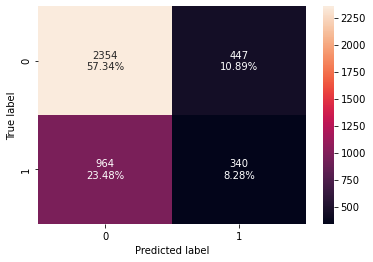

In [213]:
confusion_matrix_sklearn(bagging, X_test, y_test)

In [214]:
bagging_model_train_perf=model_performance_classification_sklearn(bagging, X_train, y_train)
print("Training performance \n",bagging_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.89    0.72       0.92 0.81


In [215]:
bagging_model_test_perf=model_performance_classification_sklearn(bagging, X_test, y_test)
print("Testing performance \n",bagging_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.66    0.26       0.43 0.33


**Bagging Classifier with weighted decision tree**



In [216]:
from sklearn.tree import DecisionTreeClassifier
bagging_wt = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='gini',class_weight={0:0.31,1:0.69},random_state=1),random_state=1)
bagging_wt.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 0.31,
                                                                      1: 0.69},
                                                        random_state=1),
                  random_state=1)

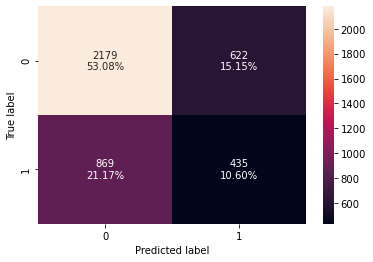

In [217]:
confusion_matrix_sklearn(bagging_wt,X_test,y_test)

In [218]:
bagging_wt_model_train_perf=model_performance_classification_sklearn(bagging_wt,X_train,y_train)
print("Training performance \n",bagging_wt_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.87    0.84       0.77 0.80


In [219]:
bagging_wt_model_test_perf=model_performance_classification_sklearn(bagging_wt, X_test, y_test)
print("Testing performance \n",bagging_wt_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.64    0.33       0.41 0.37


### Boosting Classifier

In [220]:
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=1)

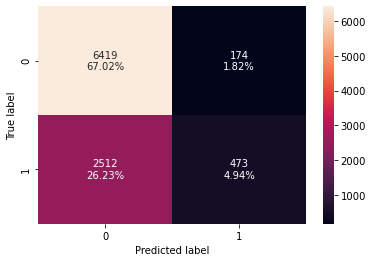

In [221]:
confusion_matrix_sklearn(gb_classifier, X_train, y_train)

In [222]:
gb_classifier_model_train_perf = model_performance_classification_sklearn(
    gb_classifier, X_train, y_train
)
gb_classifier_model_train_perf

,Accuracy,Recall,Precision,F1
0,0.72,0.16,0.73,0.26


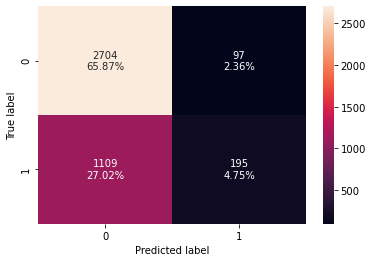

In [223]:
confusion_matrix_sklearn(gb_classifier, X_test, y_test)

In [224]:
gb_classifier_model_test_perf = model_performance_classification_sklearn(
    gb_classifier, X_test, y_test
)
gb_classifier_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.71,0.15,0.67,0.24


### Weighted Random Forest

In [225]:
from sklearn.ensemble import RandomForestClassifier
rf_wt = RandomForestClassifier(class_weight={0:0.31,1:0.69}, random_state=1)
rf_wt.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 0.31, 1: 0.69}, random_state=1)

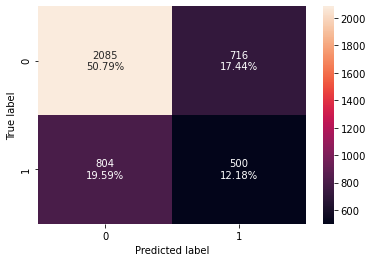

In [226]:
confusion_matrix_sklearn(rf_wt,X_test,y_test)

In [227]:
rf_model_train_perf=model_performance_classification_sklearn(rf_wt,X_train,y_train)
print("Training performance \n",rf_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.90    0.91       0.79 0.84


In [228]:
rf_classifier_model_test_perf = model_performance_classification_sklearn(
    rf_wt, X_test, y_test
)
rf_classifier_model_test_perf

,Accuracy,Recall,Precision,F1
0,0.63,0.38,0.41,0.40


### Lime Value

In [244]:
import lime
import lime.lime_tabular

In [245]:
predict_fn_rf = lambda x: rf_wt.predict_proba(x).astype(float)
X = X_train.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names = X_train.columns,class_names=['Will opt-out','Will opt-in'],kernel_width=5)

In [246]:
X_train

,YTD Customer Calls,YTD Brand A New Sales,YTD Brand A Total Sales,YTD Brand B Total Sales,Segment 1 STATUS_Y,PROVINCE_AGG_British Columbia,PROVINCE_AGG_Ontario,PROVINCE_AGG_Other,PROVINCE_AGG_Quebec,Specialty_1_AGG_Family Practice,Specialty_1_AGG_General Practice,Specialty_1_AGG_Internal Medicine,Specialty_1_AGG_Other
Customer_ID,,,,,,,,,,,,,
1325,0,0,18,0,0,0,0,0,0,1,0,0,0
11740,1,4,76,0,0,0,0,0,1,1,0,0,0
4753,1,0,82,0,0,0,1,0,0,1,0,0,0
2015,3,1,118,0,0,0,0,0,1,1,0,0,0
11805,0,1,46,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,1,4,174,0,0,0,1,0,0,1,0,0,0
7665,0,0,4,0,0,0,0,0,1,1,0,0,0
8747,3,0,68,0,1,0,0,1,0,0,1,0,0


In [247]:
choosen_instance = X_train.loc[[1325]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=10)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


### Shap Value

In [243]:
X_train.loc[[1325]]

,YTD Customer Calls,YTD Brand A New Sales,YTD Brand A Total Sales,YTD Brand B Total Sales,Segment 1 STATUS_Y,PROVINCE_AGG_British Columbia,PROVINCE_AGG_Ontario,PROVINCE_AGG_Other,PROVINCE_AGG_Quebec,Specialty_1_AGG_Family Practice,Specialty_1_AGG_General Practice,Specialty_1_AGG_Internal Medicine,Specialty_1_AGG_Other
Customer_ID,,,,,,,,,,,,,
1325,0,0,18,0,0,0,0,0,0,1,0,0,0


In [238]:
import shap 
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(rf_wt)
choosen_instance = X_train.loc[[1325]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

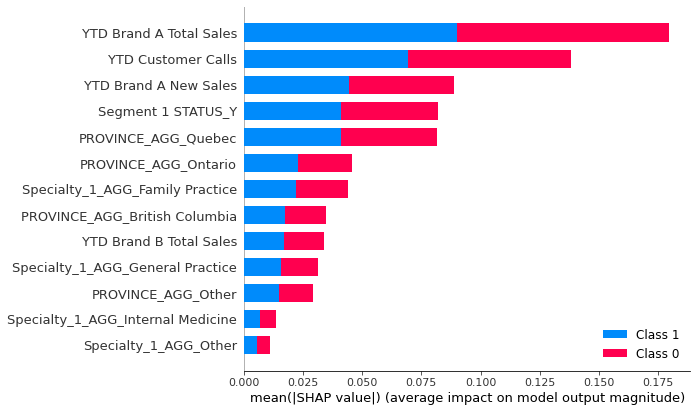

In [241]:
shap_values = shap.TreeExplainer(rf_wt).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")


### Tuning Models

### Using GridSearch for Hyperparameter tuning model

* Hyperparameter tuning is also tricky in the sense that there is no direct way to calculate how a change in the
  hyperparameter value will reduce the loss of your model, so we usually resort to experimentation. i.e we'll use Grid search
* Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. 
* It is an exhaustive search that is performed on a the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

**Tuning Random Forest**

In [139]:
# Choose the type of classifier. 
rf_estimator = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {  
        "n_estimators": [110,251,501],
        "min_samples_leaf": np.arange(1, 6,1),
        "max_features": [0.7,0.9,'log2','auto'],
        "max_samples": [0.7,0.9,None],
}

# Run the grid search
grid_obj = GridSearchCV(rf_estimator, parameters, scoring='recall',cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_estimator.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', n_estimators=501, random_state=1)

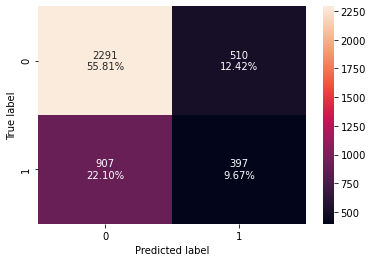

In [140]:
confusion_matrix_sklearn(rf_estimator, X_test,y_test)

In [141]:
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator, X_train,y_train)
print("Training performance \n",rf_estimator_model_train_perf)

Training performance 
    Accuracy  Recall  Precision   F1
0      0.91    0.77       0.94 0.84


In [142]:
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator, X_test, y_test)
print("Testing performance \n",rf_estimator_model_test_perf)

Testing performance 
    Accuracy  Recall  Precision   F1
0      0.65    0.30       0.44 0.36


In [143]:
feature_names = X_train.columns

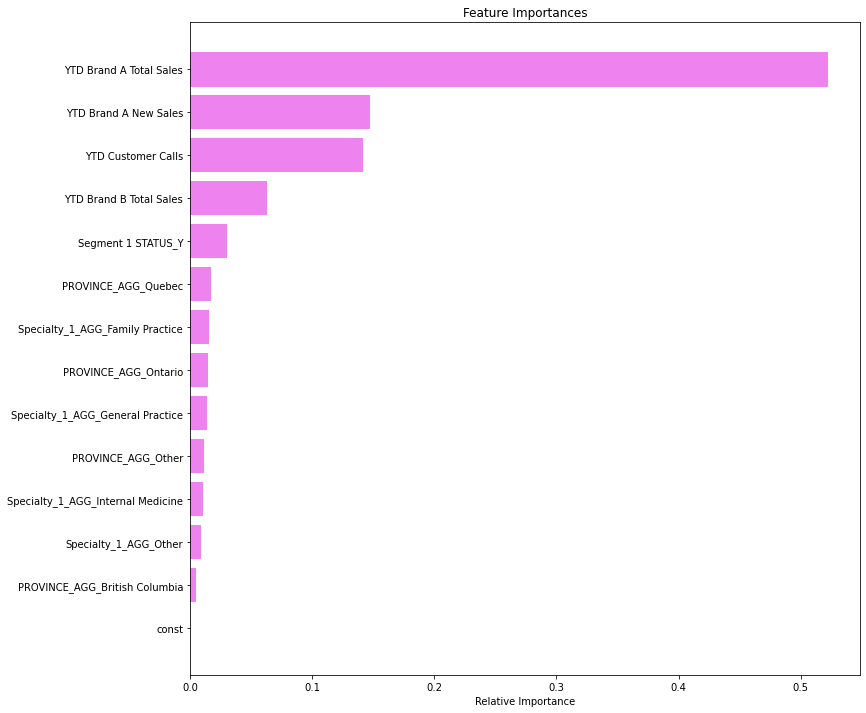

In [144]:
importances = rf_estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [166]:
models_train_comp_df = pd.concat(
    [
        rf_estimator_model_train_perf.T,
        rf_model_train_perf.T,
        gb_classifier_model_train_perf.T,
        bagging_model_train_perf.T,
        bagging_wt_model_train_perf.T,
        log_reg_model_train_perf_threshold_curve.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Tuned Random Forest",
    "Weighted Random Forest",
    "Gradient Boost Classifier",
    "Bagging Classifier",
    "Weighted Bagging Classifier",
    "Logistic Regression"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Tuned Random Forest,Weighted Random Forest,Gradient Boost Classifier,Bagging Classifier,Weighted Bagging Classifier,Logistic Regression
Accuracy,0.91,0.90,0.72,0.89,0.87,0.66
Recall,0.77,0.91,0.16,0.72,0.84,0.43
Precision,0.94,0.79,0.73,0.91,0.77,0.46
F1,0.84,0.84,0.26,0.81,0.80,0.44


In [188]:
models_test_comp_df = pd.concat(
    [
        bagging_model_test_perf.T,
        bagging_wt_model_test_perf.T,
        gb_classifier_model_test_perf.T,
        rf_classifier_model_test_perf.T,
        rf_estimator_model_test_perf.T,
        lg_test.T
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Bagging Classifier",
    "Weighted Bagging Classifier",
    "Gradient Boost Classifier",
    "Weighted Random Forest",
    "Tuned Random Forest",
    "Logistic Regression"
]
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Bagging Classifier,Weighted Bagging Classifier,Gradient Boost Classifier,Weighted Random Forest,Tuned Random Forest,Logistic Regression
Accuracy,0.66,0.64,0.71,0.63,0.65,0.71
Recall,0.26,0.33,0.15,0.38,0.30,0.16
Precision,0.43,0.41,0.67,0.41,0.44,0.66
F1,0.33,0.37,0.24,0.40,0.36,0.25


### Recommendations

**The profile of the customers who are more likely to opt in of communications:**

**Primary information to look at:**
- `YTD Brand A Total Sales` - Customers who have contributed to Brand A Total Sales 
- `YTD Brand A New Sales` -  Customers who have contributed to Brand A New Sales
- `YTD Customer Calls` -  Customers who have called XYZ Pharma before


**Secondary information to look at:**

- `Segment 1 Status Y`    -  Customers who belong to Segment 1 Status Y
- `Provinces`       - In Order of importance- Quebec, Ontario, Other
- `Speciality 1` - My analysis suggests that the customers who are more likely to opt-in are likely to have these specialities in common. We could tune our targeting to target the following specialities-
    * Family Practice
    * General Practice
    * Internal Medicine
    
    
**The profile of the customers who are more likely to opt out of communications:
**Primary information to look at:**
- `YTD Customer Calls` - Customers who have have never contributed to Calls
- `Segment 1 Status N` - Customers who have belong to Segment 1 status N 


**Secondary information to look at:**

- `BC`    - Customers who reside in BC have considerably lower chance of opting in. 
- `Speciality Other`       - Customers who have other specialty have considerably lower chance of opting in.

-----------

* Additional information of employers and employees can be collected to gain better insights.

### Appendix (Contains code for Logistic  Regression)

In [97]:
# fitting logistic regression model
logit = sm.Logit(y_train, X_train.astype(float))
lg = logit.fit(disp=False)

print(lg.summary())

                           Logit Regression Results                           
Dep. Variable:         CONSENT STATUS   No. Observations:                 9578
Model:                          Logit   Df Residuals:                     9564
Method:                           MLE   Df Model:                           13
Date:                Thu, 02 Jun 2022   Pseudo R-squ.:                 0.05433
Time:                        20:52:27   Log-Likelihood:                -5619.5
converged:                       True   LL-Null:                       -5942.3
Covariance Type:            nonrobust   LLR p-value:                1.347e-129
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -1.1753      0.116    -10.132      0.000      -1.403      -0.948
YTD Customer Calls                    0.1462      0.012     11

In [98]:
print("Training performance:")
model_performance_classification_statsmodels(lg, X_train, y_train)

Training performance:


,Accuracy,Recall,Precision,F1
0,0.61,0.59,0.41,0.49


In [99]:
vif_series = pd.Series(
    [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])],
    index=X_train.columns,
    dtype=float,
)
print("Series before feature selection: \n\n{}\n".format(vif_series))

Series before feature selection: 

const                               26.95
YTD Customer Calls                   1.25
YTD Brand A New Sales                1.60
YTD Brand A Total Sales              1.76
YTD Brand B Total Sales              1.11
Segment 1 STATUS_Y                   1.24
PROVINCE_AGG_British Columbia        2.03
PROVINCE_AGG_Ontario                 3.17
PROVINCE_AGG_Other                   2.22
PROVINCE_AGG_Quebec                  2.93
Specialty_1_AGG_Family Practice      3.82
Specialty_1_AGG_General Practice     3.29
Specialty_1_AGG_Internal Medicine    1.83
Specialty_1_AGG_Other                1.53
dtype: float64



In [100]:
# running a loop to drop variables with high p-value

# initial list of columns
cols = X_train.columns.tolist()

# setting an initial max p-value
max_p_value = 1

while len(cols) > 0:
    # defining the train set
    X_train_aux = X_train[cols]

    # fitting the model
    model = sm.Logit(y_train, X_train_aux).fit(disp=False)

    # getting the p-values and the maximum p-value
    p_values = model.pvalues
    max_p_value = max(p_values)

    # name of the variable with maximum p-value
    feature_with_p_max = p_values.idxmax()

    if max_p_value > 0.05:
        cols.remove(feature_with_p_max)
    else:
        break

selected_features = cols
print(selected_features)

['const', 'YTD Customer Calls', 'YTD Brand A Total Sales', 'YTD Brand B Total Sales', 'Segment 1 STATUS_Y', 'PROVINCE_AGG_British Columbia', 'PROVINCE_AGG_Quebec']


In [101]:
X_train2 = X_train[selected_features]

In [102]:
logit2 = sm.Logit(y_train, X_train2.astype(float))
lg2 = logit2.fit(disp=False)

print(lg2.summary())

                           Logit Regression Results                           
Dep. Variable:         CONSENT STATUS   No. Observations:                 9578
Model:                          Logit   Df Residuals:                     9571
Method:                           MLE   Df Model:                            6
Date:                Thu, 02 Jun 2022   Pseudo R-squ.:                 0.05331
Time:                        20:52:28   Log-Likelihood:                -5625.5
converged:                       True   LL-Null:                       -5942.3
Covariance Type:            nonrobust   LLR p-value:                1.308e-133
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -1.2626      0.041    -30.796      0.000      -1.343      -1.182
YTD Customer Calls                0.1543      0.012     12.741      0.000 

In [103]:
print("Training performance:")
model_performance_classification_statsmodels(lg, X_train, y_train)

Training performance:


,Accuracy,Recall,Precision,F1
0,0.61,0.59,0.41,0.49


In [176]:
print("Test performance:")
lg_test=model_performance_classification_statsmodels(lg, X_test, y_test)
lg_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.71,0.16,0.66,0.25


In [104]:
# converting coefficients to odds
odds = np.exp(lg2.params)

# finding the percentage change
perc_change_odds = (np.exp(lg2.params) - 1) * 100

# removing limit from number of columns to display
pd.set_option("display.max_columns", None)

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=X_train2.columns).T

,const,YTD Customer Calls,YTD Brand A Total Sales,YTD Brand B Total Sales,Segment 1 STATUS_Y,PROVINCE_AGG_British Columbia,PROVINCE_AGG_Quebec
Odds,0.28,1.17,1.00,1.01,1.70,1.26,0.49
Change_odd%,-71.71,16.69,0.06,0.62,70.38,25.67,-50.70


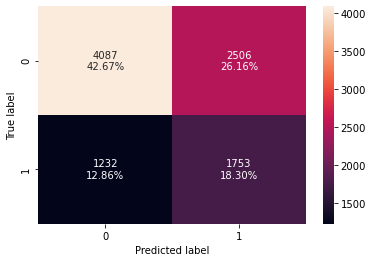

In [105]:
# creating confusion matrix
confusion_matrix_statsmodels(lg2, X_train2, y_train)

#### ROC-AUC

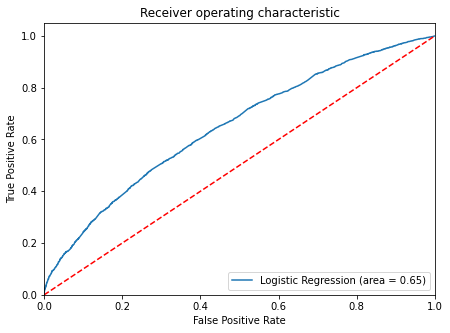

In [109]:
logit_roc_auc_train = roc_auc_score(y_train, lg2.predict(X_train2))
fpr, tpr, thresholds = roc_curve(y_train, lg2.predict(X_train2))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

### Optimal threshold using AUC-ROC curve


In [121]:
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr = fpr 
fpr, tpr, thresholds = roc_curve(y_train, lg2.predict(X_train2))

optimal_idx = np.argmax(tpr - fpr)
# Argmax is an operation that finds the argument that gives the maximum value from a target function.
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)



0.326461775451011


In [123]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99332626, 0.99332626,
       1.        ])

In [126]:
thresholds

array([1.98957254, 0.98957254, 0.8996088 , ..., 0.12253432, 0.12246479,
       0.1223953 ])

In [168]:
# checking model performance for this model
log_reg_model_train_perf_threshold_auc_roc = model_performance_classification_statsmodels(
    lg2, X_train2, y_train, threshold=optimal_threshold_auc_roc
)
print("Training performance:")
log_reg_model_train_perf_threshold_auc_roc

Training performance:


,Accuracy,Recall,Precision,F1
0,0.65,0.48,0.44,0.46


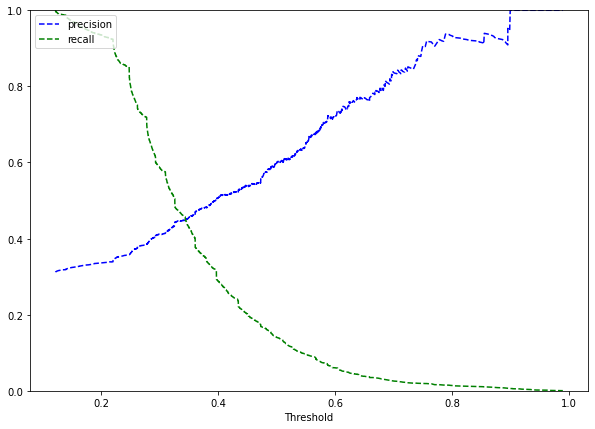

In [169]:
y_scores = lg2.predict(X_train2)
prec, rec, tre = precision_recall_curve(y_train, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

In [116]:
# setting the threshold
optimal_threshold_curve = 0.35

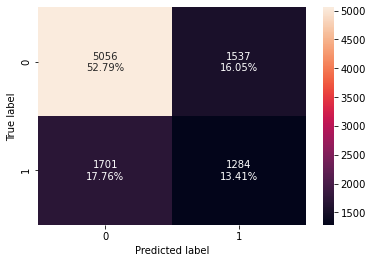

In [170]:
# creating confusion matrix
confusion_matrix_statsmodels(lg2, X_train2, y_train, threshold=optimal_threshold_curve)

In [174]:
log_reg_model_train_perf_threshold_curve = model_performance_classification_statsmodels(
    lg2, X_train2, y_train, threshold=optimal_threshold_curve
)
print("Training performance:")
log_reg_model_train_perf_threshold_curve

Training performance:


,Accuracy,Recall,Precision,F1
0,0.66,0.43,0.46,0.44
